In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pprint
from pathlib import Path
from tqdm import trange

from flygym.vision import Retina
from flygym.util import get_data_path
from flygym.arena import FlatTerrain, GappedTerrain
from flygym.examples.obstacle_arena import ObstacleOdorArena
from flygym import Fly, Camera, SingleFlySimulation
from flygym.preprogrammed import all_leg_dofs

retina = Retina()

In [3]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs

# Load recorded data
data_path = get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

# Interpolate 5x
num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), num_steps))
measure_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
interp_t = np.arange(num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [5]:
coms = np.empty((retina.num_ommatidia_per_eye, 2))
for i in range(retina.num_ommatidia_per_eye):
    mask = retina.ommatidia_id_map == i + 1
    coms[i, :] = np.argwhere(mask).mean(axis=0)

In [11]:
def sample_visual_data(
    sim,
    obstacle_positions,
    action,
    visualize=False,
    camera="birdeye_cam_origin",
    obj_threshold=40,
):
    # Change obstacle positions in the arena
    for i in range(obstacle_positions.shape[0]):
        pos_xyz = np.array([*obstacle_positions[i, :], sim.arena.obstacle_z_pos])
        sim.physics.bind(sim.arena.obstacle_bodies[i]).mocap_pos = pos_xyz
    sim.step(action)

    # Render visual input
    fly = sim.fly
    fly._last_vision_update_time = -np.inf  # hack: this forces visual input update
    fly._update_vision(sim)
    visual_input = fly._curr_visual_input.copy()
    raw_cam_imgs = fly._curr_raw_visual_input.copy()

    # Calculate obstacle positions relative to the fly
    fly_rotation = sim.get_observation()["fly"][2, 0] - np.pi / 2
    rot_matrix = np.array(
        [
            [np.cos(fly_rotation), -np.sin(fly_rotation)],
            [np.sin(fly_rotation), np.cos(fly_rotation)],
        ]
    )
    obstacle_positions_transformed = obstacle_positions - fly.spawn_pos[:2]
    obstacle_positions_transformed[:, 1] *= -1  # change y to right-hand-positive
    obstacle_positions_transformed = (rot_matrix @ obstacle_positions_transformed.T).T

    # Centroid y position and relative size
    y_pos_li = []
    size_li = []
    for i in range(2):
        all_pale_intensities = retina.raw_image_to_hex_pxls(
            np.ascontiguousarray(fly._curr_raw_visual_input[i]),
        )
        obj_mask = all_pale_intensities.max(axis=1) < obj_threshold
        obj_ommatidia_coords = coms[obj_mask]
        obj_size = obj_ommatidia_coords.shape[0]
        if obj_size > 0:
            _, mean_y = obj_ommatidia_coords.mean(axis=0)
            mean_y /= retina.ncols
            rel_size = obj_size / retina.num_ommatidia_per_eye
            if i == 0:
                mean_y = 1 - mean_y
        else:
            mean_y = 0
            rel_size = 0
        y_pos_li.append(mean_y)
        size_li.append(rel_size)
    azimuth = np.array(y_pos_li)
    rel_size = np.array(size_li)

    # Visualize
    if visualize:
        fig, axs = plt.subplots(1, 5, figsize=(10, 5), tight_layout=True)
        birdeye_img = sim.physics.render(camera_id=camera, height=512, width=512)
        axs[0].imshow(birdeye_img)
        axs[0].axis("off")
        for i in range(2):
            axs[i + 1].imshow(raw_cam_imgs[i], cmap="gray", vmin=0, vmax=1)
            axs[i + 1].axis("off")
        for i in range(2):
            vis = retina.hex_pxls_to_human_readable(visual_input[i].max(-1))
            axs[i + 3].imshow(vis, cmap="gray", vmin=0, vmax=1)
            axs[i + 3].axis("off")

    return {
        "visual_input": visual_input,
        "obstacle_positions_transformed": obstacle_positions_transformed,
        "azimuth": azimuth,
        "rel_size": rel_size,
    }

  0%|          | 0/2 [00:00<?, ?it/s]

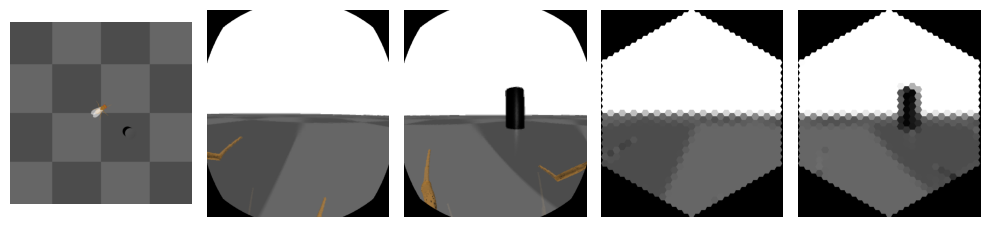

{'azimuth': array([0.50314029, 0.49685971]),
 'fly_heading': 2.1816943,
 'fly_pos': array([0.19722943, 0.87168086], dtype=float32),
 'fly_state_idx': 0,
 'obstacle_dir': -0.7264511579796973,
 'obstacle_dist': 6.988509574287779,
 'obstacle_pos': array([ 5.42139416, -3.77023351]),
 'obstacle_position_rel': array([1.62894473, 6.79007785]),
 'obstacle_state_idx': 0,
 'rel_size': array([1., 1.]),
 'terrain': 'flat',
 'visual_input': array([[[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.4       , 0.        ],
        [0.4       , 0.        ],
        [0.4       , 0.        ]],

       [[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.29803922, 0.        ],
        [0.29803922, 0.        ],
        [0.31636241, 0.        ]]])}


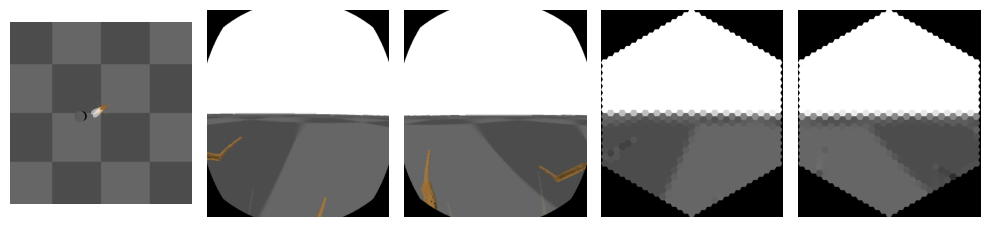

 50%|█████     | 1/2 [00:01<00:01,  1.39s/it]

{'azimuth': array([0.50314029, 0.49685971]),
 'fly_heading': 2.1810477,
 'fly_pos': array([0.19709489, 0.8711931 ], dtype=float32),
 'fly_state_idx': 0,
 'obstacle_dir': -2.785254507782425,
 'obstacle_dist': 4.380276852355778,
 'obstacle_pos': array([-3.90801526, -0.65684352]),
 'obstacle_position_rel': array([-4.23308867, -1.10493974]),
 'obstacle_state_idx': 1,
 'rel_size': array([1., 1.]),
 'terrain': 'flat',
 'visual_input': array([[[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.4       , 0.        ],
        [0.4       , 0.        ],
        [0.4       , 0.        ]],

       [[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.29803922, 0.        ],
        [0.29803922, 0.        ],
        [0.31489182, 0.        ]]])}


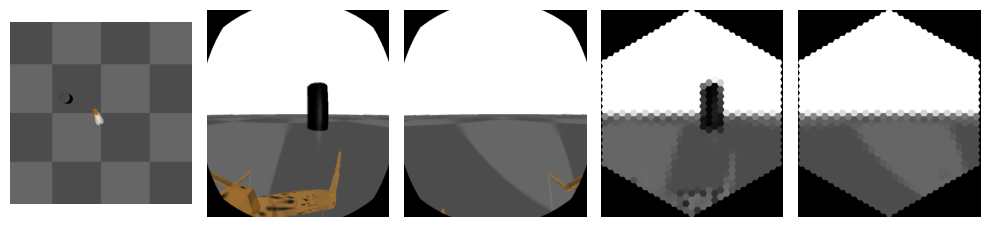

{'azimuth': array([0.50314029, 0.49685971]),
 'fly_heading': -2.7711215,
 'fly_pos': array([-0.91207534, -0.08110447], dtype=float32),
 'fly_state_idx': 1,
 'obstacle_dir': 2.6741025445054722,
 'obstacle_dist': 6.5443564887514585,
 'obstacle_pos': array([-6.75423661,  2.86809095]),
 'obstacle_position_rel': array([ 4.87374274, -4.37669236]),
 'obstacle_state_idx': 0,
 'rel_size': array([1., 1.]),
 'terrain': 'flat',
 'visual_input': array([[[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.29803922, 0.        ],
        [0.29803922, 0.        ],
        [0.29803922, 0.        ]],

       [[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.29803922, 0.        ],
        [0.29803922, 0.        ],
        [0.29803922, 0.        ]]])}


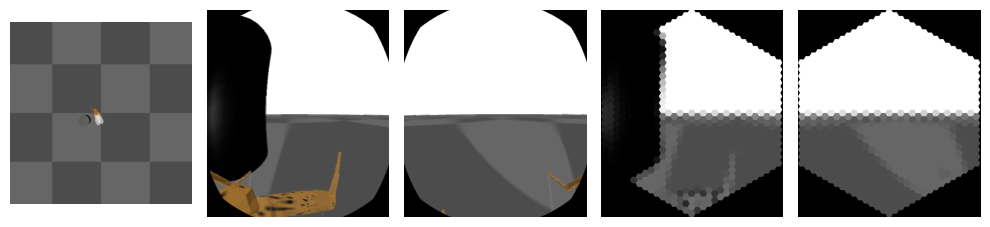

100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


{'azimuth': array([0.50314029, 0.49685971]),
 'fly_heading': -2.77094,
 'fly_pos': array([-0.9119533 , -0.08114588], dtype=float32),
 'fly_state_idx': 1,
 'obstacle_dir': -2.594143117880226,
 'obstacle_dist': 2.5682884655830955,
 'obstacle_pos': array([-3.10489881, -1.41796879]),
 'obstacle_position_rel': array([-0.4426589 , -2.52777262]),
 'obstacle_state_idx': 1,
 'rel_size': array([1., 1.]),
 'terrain': 'flat',
 'visual_input': array([[[1.69033130e-05, 0.00000000e+00],
        [3.67748759e-03, 0.00000000e+00],
        [1.14604462e-02, 0.00000000e+00],
        ...,
        [2.98039216e-01, 0.00000000e+00],
        [2.98039216e-01, 0.00000000e+00],
        [2.98039216e-01, 0.00000000e+00]],

       [[9.91379310e-01, 0.00000000e+00],
        [1.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 0.00000000e+00],
        ...,
        [2.98039216e-01, 0.00000000e+00],
        [2.98039216e-01, 0.00000000e+00],
        [2.98039216e-01, 0.00000000e+00]]])}


  0%|          | 0/2 [00:00<?, ?it/s]

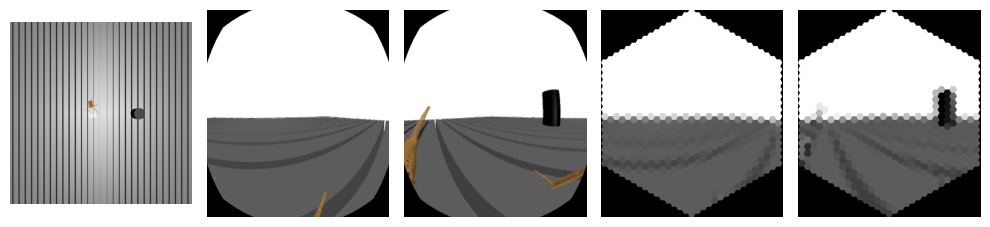

{'azimuth': array([0.50314029, 0.49685971]),
 'fly_heading': -2.9939687,
 'fly_pos': array([-1.9218931,  1.3434836], dtype=float32),
 'fly_state_idx': 0,
 'obstacle_dir': -0.16582554216397138,
 'obstacle_dist': 8.96069806686749,
 'obstacle_pos': array([ 6.91588587, -0.13562844]),
 'obstacle_position_rel': array([-2.74757719,  8.5239506 ]),
 'obstacle_state_idx': 0,
 'rel_size': array([1., 1.]),
 'terrain': 'gapped',
 'visual_input': array([[[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.36078431, 0.        ],
        [0.36078431, 0.        ],
        [0.36078431, 0.        ]],

       [[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.32158553, 0.        ],
        [0.36078431, 0.        ],
        [0.36078431, 0.        ]]])}


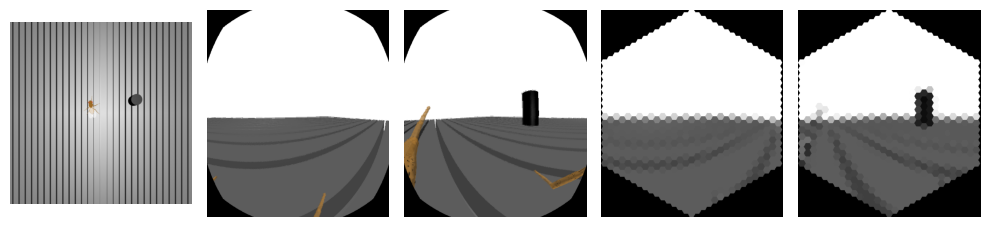

 50%|█████     | 1/2 [00:01<00:01,  1.91s/it]

{'azimuth': array([0.50314029, 0.49685971]),
 'fly_heading': -2.9942164,
 'fly_pos': array([-1.9218367,  1.3435836], dtype=float32),
 'fly_state_idx': 0,
 'obstacle_dir': 0.12866379864420052,
 'obstacle_dist': 8.407286015837155,
 'obstacle_pos': array([6.41595655, 2.42231489]),
 'obstacle_position_rel': array([-0.14199545,  8.40509073]),
 'obstacle_state_idx': 1,
 'rel_size': array([1., 1.]),
 'terrain': 'gapped',
 'visual_input': array([[[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.36078431, 0.        ],
        [0.36078431, 0.        ],
        [0.36078431, 0.        ]],

       [[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.32168695, 0.        ],
        [0.36078431, 0.        ],
        [0.36078431, 0.        ]]])}


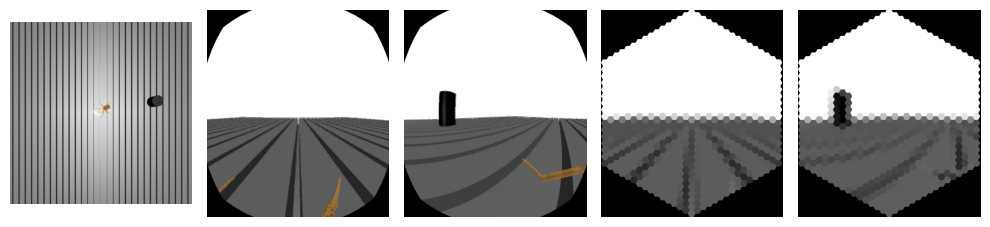

{'azimuth': array([0.50314029, 0.49685971]),
 'fly_heading': 2.048605,
 'fly_pos': array([0.72715175, 0.8833141 ], dtype=float32),
 'fly_state_idx': 1,
 'obstacle_dir': 0.13727705420658243,
 'obstacle_dist': 9.557351336396671,
 'obstacle_pos': array([10.19459033,  2.1912022 ]),
 'obstacle_position_rel': array([9.01987986, 3.19487067]),
 'obstacle_state_idx': 0,
 'rel_size': array([1., 1.]),
 'terrain': 'gapped',
 'visual_input': array([[[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.30882353, 0.        ],
        [0.36078431, 0.        ],
        [0.21438472, 0.        ]],

       [[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.36078431, 0.        ],
        [0.36080052, 0.        ],
        [0.36178161, 0.        ]]])}


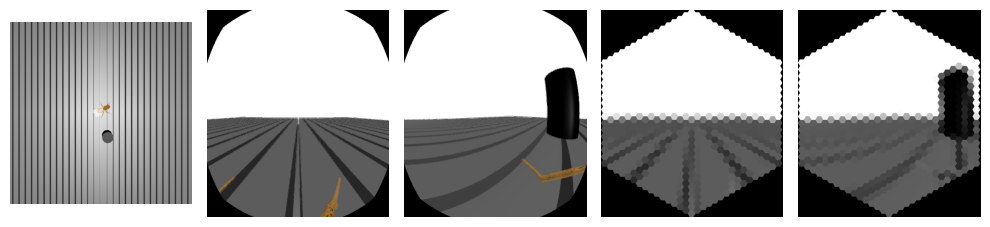

100%|██████████| 2/2 [00:03<00:00,  1.90s/it]

{'azimuth': array([0.50314029, 0.49685971]),
 'fly_heading': 2.0484025,
 'fly_pos': array([0.7273034 , 0.88318425], dtype=float32),
 'fly_state_idx': 1,
 'obstacle_dir': -1.479340718682099,
 'obstacle_dist': 5.317295519924189,
 'obstacle_pos': array([ 1.21292226, -4.41188949]),
 'obstacle_position_rel': array([-1.99095812,  4.93096146]),
 'obstacle_state_idx': 1,
 'rel_size': array([1., 1.]),
 'terrain': 'gapped',
 'visual_input': array([[[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.31337052, 0.        ],
        [0.36078431, 0.        ],
        [0.21075051, 0.        ]],

       [[0.99137931, 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [0.36078431, 0.        ],
        [0.36078431, 0.        ],
        [0.36262677, 0.        ]]])}


In [12]:
fly_pos_range = [-2, 2]
fly_heading_range = [-np.pi, np.pi]
obs_dist_range = [2, 10]
obs_dir_range = [-np.pi, np.pi]
fly_pos_idx_range = [0, data_block.shape[1] - 1]
num_fly_state_samples = 2
num_obstacle_state_samples_per_fly_state = 2
debug = True

res_all = []

np.random.seed(0)

for terrain in ["flat", "gapped"]:
    for i in trange(num_fly_state_samples):
        if terrain == "flat":
            terrain_arena = FlatTerrain()
        elif terrain == "gapped":
            terrain_arena = GappedTerrain(
                x_range=(-20, 20), y_range=(-20, 20), gap_width=0.25, ground_alpha=1
            )
        else:
            raise ValueError(f"Unknown terrain: {terrain}")

        arena = ObstacleOdorArena(
            terrain=terrain_arena,
            obstacle_positions=np.array([[10, 0]]),
            marker_size=0.5,
            obstacle_colors=(0, 0, 0, 1),
            user_camera_settings=((16, -30, 11), (np.deg2rad(75), 0, 0), 30),
        )

        fly = Fly(
            enable_vision=True,
            render_raw_vision=True,
            enable_olfaction=True,
            spawn_pos=(*np.random.uniform(*fly_pos_range, size=(2,)), 0.2),
            spawn_orientation=(0, 0, np.pi / 2 + np.random.uniform(*fly_heading_range)),
            head_stabilization_kp=1000,
            actuator_kp=18,
        )

        cam = Camera(
            fly=fly,
            camera_id="user_cam",
            play_speed=0.2,
        )

        sim = SingleFlySimulation(
            fly=fly,
            cameras=[cam],
            arena=arena,
        )
        action = {"joints": data_block[:, np.random.randint(*fly_pos_idx_range)]}
        for _ in range(50):
            sim.step(action)

        num_obs_states_sampled = 0
        while num_obs_states_sampled < num_obstacle_state_samples_per_fly_state:
            fly_pos = sim.get_observation()["fly"][0, :2]
            fly_heading = sim.get_observation()["fly"][2, 0]
            obs_dist = np.random.uniform(*obs_dist_range)
            obs_dir = np.random.uniform(*obs_dir_range)
            obs_dx = obs_dist * np.cos(obs_dir)
            obs_xy = obs_dist * np.sin(obs_dir)
            obstacle_position = np.array([obs_dx, obs_xy]) + fly_pos
            sample = sample_visual_data(
                sim,
                obstacle_position.reshape(1, -1),
                action=action,
                visualize=debug,
            )
            entry = {
                "terrain": terrain,
                "fly_state_idx": i,
                "obstacle_state_idx": num_obs_states_sampled,
                "visual_input": sample["visual_input"],
                "obstacle_position_rel": sample["obstacle_positions_transformed"][0],
                "azimuth": sample["azimuth"],
                "rel_size": sample["rel_size"],
                "fly_pos": fly_pos,
                "obstacle_pos": obstacle_position,
                "fly_heading": fly_heading,
                "obstacle_dist": obs_dist,
                "obstacle_dir": obs_dir,
            }
            res_all.append(entry)
            num_obs_states_sampled += 1
            if debug:
                plt.show()
                pprint.pprint(entry)

In [8]:
fly_pos_range = [-2, 2]
fly_heading_range = [-np.pi, np.pi]
obs_dist_range = [0, 10]
obs_dir_range = [-np.pi, np.pi]
fly_pos_idx_range = [0, data_block.shape[1] - 1]
num_fly_state_samples = 1000
num_obstacle_state_samples_per_fly_state = 10
debug = False

res_all = []

np.random.seed(0)

for terrain in ["flat", "gapped"]:
    for i in trange(num_fly_state_samples):
        if terrain == "flat":
            terrain_arena = FlatTerrain()
        elif terrain == "gapped":
            terrain_arena = GappedTerrain(
                x_range=(-20, 20), y_range=(-20, 20), gap_width=0.25, ground_alpha=1
            )
        else:
            raise ValueError(f"Unknown terrain: {terrain}")
        arena = ObstacleOdorArena(
            terrain=terrain_arena,
            obstacle_positions=np.array([[10, 0]]),
            marker_size=0.5,
            obstacle_colors=(0, 0, 0, 1),
            user_camera_settings=((16, -30, 11), (np.deg2rad(75), 0, 0), 30),
        )

        fly = Fly(
            enable_vision=True,
            render_raw_vision=True,
            enable_olfaction=True,
            spawn_pos=(*np.random.uniform(*fly_pos_range, size=(2,)), 0.2),
            spawn_orientation=(0, 0, np.pi / 2 + np.random.uniform(*fly_heading_range)),
            actuator_kp=18,
            head_stabilization_kp=1000,
        )

        cam = Camera(
            fly=fly,
            camera_id="user_cam",
            play_speed=0.2,
        )
        sim = SingleFlySimulation(
            fly=fly,
            cameras=[cam],
            arena=arena,
        )

        action = {"joints": data_block[:, np.random.randint(*fly_pos_idx_range)]}

        for _ in range(50):
            sim.step(action)

        num_obs_states_sampled = 0
        while num_obs_states_sampled < num_obstacle_state_samples_per_fly_state:
            fly_pos = sim.get_observation()["fly"][0, :2]
            fly_heading = sim.get_observation()["fly"][2, 0]
            obs_dist = np.random.uniform(*obs_dist_range)
            obs_dir = np.random.uniform(*obs_dir_range)
            obs_dx = obs_dist * np.cos(obs_dir)
            obs_xy = obs_dist * np.sin(obs_dir)
            obstacle_position = np.array([obs_dx, obs_xy]) + fly_pos
            sample = sample_visual_data(
                sim,
                obstacle_position.reshape(1, -1),
                action=action,
                visualize=debug,
            )
            entry = {
                "terrain": terrain,
                "fly_state_idx": i,
                "obstacle_state_idx": num_obs_states_sampled,
                "visual_input": sample["visual_input"],
                "obstacle_position_rel": sample["obstacle_positions_transformed"][0],
                "azimuth": sample["azimuth"],
                "rel_size": sample["rel_size"],
                "fly_pos": fly_pos,
                "obstacle_pos": obstacle_position,
                "fly_heading": fly_heading,
                "obstacle_dist": obs_dist,
                "obstacle_dir": obs_dir,
            }
            res_all.append(entry)
            num_obs_states_sampled += 1
            if debug:
                plt.show()
                pprint.pprint(entry)

100%|██████████| 1000/1000 [30:30<00:00,  1.83s/it]


In [10]:
Path("data/vision").mkdir(parents=True, exist_ok=True)
with open("data/vision/visual_training_data.pkl", "wb") as f:
    pickle.dump(res_all, f)